In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('training_points_v3_covar.csv',low_memory=False)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(len(df))
df = df.drop(df.loc[df['oc']=='<6'].index) # 231
print(len(df))
df = df.drop(df.loc[df['oc']=='< LOD'].index)  # 33, lucas 2018
print(len(df))
df = df.drop(df.loc[df['oc']=='<0.0'].index)  # 2, lucas 2018
print(len(df))
# df = df.dropna(how='any')
# print(len(df))

feat_cols = df.columns.values.tolist()
a = ['oc', 'gps_lat', 'gps_long', 'time', 'ref', 'country']
for i in a:
    feat_cols.remove(i)
target_col = 'oc'

x = df[feat_cols]
y = df[target_col]

125963
125732
125699
125697


ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.poll_control_queue() running at /opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py:227> wait_for=<Future finished result=[<zmq.sugar.fr...x7f07f84a4880>, <zmq.sugar.fr...x7f07a8b57b40>, <zmq.sugar.fr...x7f07a8b57bf0>, <zmq.sugar.fr...x7f07a8b57ca0>, <zmq.sugar.fr...x7f07a8b57d50>, <zmq.sugar.fr...x7f07a8b57e00>, ...]> cb=[_chain_future.<locals>._call_set_state() at /opt/conda/lib/python3.8/asyncio/futures.py:367]>


In [ ]:
df

In [7]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#     rf = RandomForestRegressor(n_estimators=100, n_jobs=40, random_state=42)
#     cv_scores = cross_val_score(rf, x_train, y_train, cv=5, n_jobs=40) 
    
hyperpar = HalvingGridSearchCV(
    estimator = RandomForestRegressor(random_state=11),
    scoring = 'neg_mean_squared_error',
    param_grid = {
        'n_estimators': [300, 500, 800, 1000],
        'max_depth': [10, 20, 30],
        'max_features': [0.4, 0.6,0.8]},
    n_jobs = 20,
    cv = 5)

hyperpar.fit(x_train,y_train)
best_params = hyperpar.best_params_
    
best_params

{'max_depth': 30, 'max_features': 0.4, 'n_estimators': 1000}

In [10]:
# # best model
# rf = RandomForestRegressor(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     max_features=best_params['max_features'],
#     random_state=11,
#     n_jobs=20)
    
# rf.fit(x_train,y_train)



In [29]:
import joblib
joblib.dump(rf, f'model/v1.joblib')
    
r2_train = rf.score(x_train, y_train)
#     r2_train = cv_scores.mean()
y_pred = rf.predict(x_test)
y_test = pd.to_numeric(y_test)
r2_test = r2_score(y_test, y_pred)

In [30]:
print(f'train: {r2_train}')
print(f'test: {r2_test}')

train: 0.921642107880609
test: 0.45146414286608993


In [15]:
importance_scores = rf.feature_importances_

In [33]:
landmapper.save_instance('1st_model.pkl', no_train_data=False, compress='lz4')

In [17]:
feature_importance_df = pd.DataFrame({"Feature": feat_cols, "Importance": importance_scores})
feature_importance_df

,Feature,Importance
0,hzn_top,0.013241
1,hzn_bottom,0.027455
2,clm_lst_mod11a2.annual.d.daytime_m,0.074435
3,clm_lst_mod11a2.annual.d.daytime_sd,0.008232
4,clm_lst_mod11a2.annual.d.nighttime_m,0.019793
...,...,...
242,veg_evi.mod13q1_tmwm.inpaint_p90_month0506,0.012939
243,veg_evi.mod13q1_tmwm.inpaint_p90_month0708,0.010187
244,veg_evi.mod13q1_tmwm.inpaint_p90_month0910,0.009466
245,veg_evi.mod13q1_tmwm.inpaint_p90_month1112,0.010914


In [35]:
feature_importance_df.to_csv(f'model/v1_feature.importance.csv')

In [33]:
def accuracy_plot(y_test, y_pred, title = 'RegressorChain(RF)'):
    
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    rmse = mean_squared_error(y_test, y_pred, multioutput='uniform_average', squared=False)
                 
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (8,8))
    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.2f} and rmse={rmse:.4f}')
    #plt.title(f'Grain yield (kg/ha), model: {model_type} \n n = {results_bind.shape[0]}, R2:{round(r2_score(y_viz,results_bind),3)} CCC:{round(ccc(results_bind,y_viz),3)}')
    # Make the plot
    plt.hexbin(y_test, y_pred, gridsize=(300, 300) , cmap = 'plasma_r', mincnt=1, vmax = 100)#, xscale =25, yscale = 25)
    
    plt.xlabel('SOC - test'), plt.ylabel('SOC - pred')

#     plt.axis('equal')
#     plt.ylim(0, 12000), plt.xlim(0, 12000)

    # square plot
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #diagonal 
    ax.plot([-10, 300], [-10, 300], "-k", alpha = .5)
    ax.set_xlim(-10,300)
    ax.set_ylim(-10,300)
    
    # Create new axes according to image position
    cax = fig.add_axes([ax.get_position().x1+0.05,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])

    # Plot vertical colorbar
    cb = plt.colorbar(cax=cax)
    #cb.outline.set_visible(False)
    #cb.set_ticks([1,100,200,300])

    plt.show()

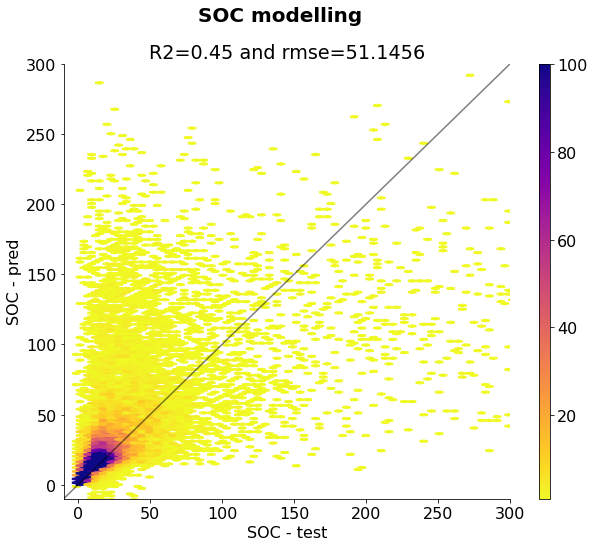

In [34]:
accuracy_plot(y_test,y_pred,'SOC modelling')

In [27]:
y_test

80025                   471.13
116974     0.35245594300712413
86821       0.3712296983758701
80418                     2.52
37558                     19.2
                  ...         
8362                     314.5
24636                    15.15
63395                     14.2
8837                       9.2
100920    0.023201856148491882
Name: oc, Length: 24337, dtype: object